In [140]:
from datetime import datetime
import math
import os

# keras
from keras import backend, regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.datasets import mnist
from keras.layers import BatchNormalization, Dense, dot, Dropout, Flatten, Input, LeakyReLU, Multiply, ReLU, Reshape
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.optimizers import Adam, SGD, Nadam
from keras.utils.vis_utils import plot_model  # to visualize model structure
# sklearn
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
% matplotlib inline

In [141]:
# パラメタ
NUM_PLOT = 10
FILE_PATH = "data/index_data.csv"
STATS_PATHS = {
    "LIQ": "data/volume_data.csv",
}
NUM_FACTOR = 5
NUM_BETA_LAG = 20
NUM_EPOCH = 3000
NUM_BATCH = 100
LR = 0.05
TRAIN_START = '2011/1/1'
TRAIN_END = '2018/12/31'
TEST_START = '2019/1/1'
TEST_END = '2019/12/31'
IS_RECURRENT = False
IS_STATS = True

# 日付演算用に型変換
TRAIN_START = datetime.strptime(TRAIN_START, '%Y/%m/%d')
TRAIN_END = datetime.strptime(TRAIN_END, '%Y/%m/%d')
TEST_START = datetime.strptime(TEST_START, '%Y/%m/%d')
TEST_END = datetime.strptime(TEST_END, '%Y/%m/%d')

In [142]:
def plot_learn_history(history, save_path="image/learn_history.png"):
    # 損失関数の推移を確認
    plt.plot(range(1, NUM_EPOCH+1), history['loss'], label="Training Loss")
    plt.plot(range(1, NUM_EPOCH+1),
             history['val_loss'], label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.savefig(save_path)
    plt.close()


def plot_factors(x_data, factors, save_path):
    factors = factors.T

    # 平均0%・標準偏差年率10%にスケーリング（年間260日基準）
    for i in range(NUM_FACTOR):
        m = np.mean(factors[i])
        sd = np.std(factors[i])
        factors[i] = [(f - m) / sd * (0.1 / math.sqrt(260))
                      for f in factors[i]]
    factors = np.array(factors)

    # 100スタートのインデックスに変形
    for i in range(NUM_FACTOR):
        factors[i] = 100 * (1 + factors[i]).cumprod()

    # 比較してプロット
    plt.figure()
    for i in range(NUM_FACTOR):
        plt.plot(x_data.index, factors[i], label="factor_{}".format(i+1))
    plt.legend(loc='upper right')
    plt.savefig(save_path)
    plt.close()

    return factors


def round_data(x_data, quantile_point=0.01):
    down_quantiles = x_data.quantile(quantile_point)
    upper_quantiles = x_data.quantile(1.0-quantile_point)
    outliers_low = (x_data < down_quantiles)
    outliers_up = (x_data > upper_quantiles)
    x_data[outliers_low] = np.nan
    x_data = x_data.fillna(down_quantiles)
    x_data[outliers_up] = np.nan
    x_data = x_data.fillna(upper_quantiles)
    return x_data


def plot_scatter_chart(x_true, x_pred, title):
    plt.scatter(np.array(x_true).flatten(),
                np.array(x_pred).flatten(),
                s=1)
    plt.plot(np.linspace(-0.2, 0.2, 1000),
             np.linspace(-0.2, 0.2, 1000),
             color="black")
    plt.title("R2:{}".format(round(calcu_r_squared(x_true, x_pred)*100, 2)),
              fontname="MS Gothic")
    plt.xlabel("実リターン", fontname="MS Gothic")
    plt.ylabel("推定リターン", fontname="MS Gothic")
    plt.xlim(-0.2, 0.2)
    plt.ylim(-0.2, 0.2)
    plt.grid(True)
    plt.savefig("image/return_scatter_{}".format(title))
    plt.show()


# ---------------------------------------------------------
# 決定係数
# see: https://statisticsbyjim.com/regression/interpret-adjusted-r-squared-predicted-r-squared-regression/
# ---------------------------------------------------------


def calcu_r_squared(ret, pred_ret, is_sep=False):
    # 決定係数を計算
    if not is_sep:
        ret = np.array(ret)
    sse = np.square((ret - pred_ret)).sum()
    sst = np.square(ret - ret.mean()).sum()
    return 1 - sse/sst


def calcu_pred_r_squared(x_data, factors, betas):
    # factorのt-1までの平均
    factors = pd.DataFrame(factors)
    factors.index = x_data.index
    factors.columns = ["factor_{}".format(i+1) for i in range(NUM_FACTOR)]
    factors = factors.expanding().mean().shift(1).dropna()

    # 個別のベータを取得してbeta*上記の平均を計算
    upper_sum = 0
    for i_firm in range(x_data.shape[1]):
        f_times_b = []
        for i_factor in range(NUM_FACTOR):
            beta = betas.T[i_factor][i_firm][1:]
            factor = factors.iloc[:, i_factor]
            f_times_b.append(beta * factor)
        f_times_b = pd.DataFrame(f_times_b).T.sum(axis=1)
        ret = x_data.iloc[1:, i_firm]
        upper_sum += np.square(ret - f_times_b).sum()
    # 合算してR-squaredに
    lower_sum = np.square(x_data.iloc[1:, :]).sum().sum()
    pred_r_squared = 1 - upper_sum / lower_sum
    return pred_r_squared

In [143]:
# データを読み込み
asset_index = pd.read_csv(FILE_PATH, encoding="shift_jis", index_col=0)
asset_index = asset_index.dropna(how="all").dropna(axis=1).dropna()

# 前日と全く同じ指数値の場合には取引なしと見なして削除
dup_list = []
for i in range(asset_index.index.shape[0]-1):
    if all(asset_index.iloc[i+1, :] == asset_index.iloc[i, :]):
        dup_list.append(i+1)
asset_index = asset_index.drop(asset_index.index[dup_list])
asset_return = asset_index.pct_change().dropna()

# 経済データを使用する場合
# モメンタム
asset_chars = asset_index.diff(5)
asset_chars = pd.concat(
    [asset_chars, asset_index.diff(20)], axis=1).dropna()
asset_chars = pd.concat([asset_chars, asset_chars.diff(1)],
                        axis=1).shift(1).dropna()
# ボラティリティ
asset_chars = pd.concat(
    [asset_chars, asset_return.rolling(5).std(ddof=0)], axis=1).dropna()
asset_chars = pd.concat(
    [asset_chars, asset_return.rolling(20).std(ddof=0)], axis=1).dropna()
# 流動性
volume = pd.read_csv(STATS_PATHS["LIQ"], encoding="shift_jis", index_col=0)
volume = volume.dropna(how="all").dropna(axis=1).dropna()
volume_sd = volume.rolling(20).std(ddof=0)
asset_chars = pd.concat([asset_chars, volume], axis=1).dropna()
asset_chars = pd.concat([asset_chars, volume_sd], axis=1).dropna()
# asset charsは一日ラグを設ける
asset_chars = asset_chars.shift(1).dropna()

# 過去NUM_BETA_LAG日前～前日のデータを使用
lag_return = asset_return.shift(1)
for i in range(NUM_BETA_LAG-1):
    lag_return = pd.concat(
        [lag_return, asset_return.shift(i+2)], axis=1)
lag_return = lag_return.dropna()

In [144]:
# インデックスの型を変更
asset_return.index = np.array([datetime.strptime(x, '%Y/%m/%d')
                               for x in asset_return.index])
asset_chars.index = np.array([datetime.strptime(x, '%Y/%m/%d')
                              for x in asset_chars.index])
lag_return.index = np.array([datetime.strptime(x, '%Y/%m/%d')
                             for x in lag_return.index])
common_index = np.intersect1d(np.intersect1d(asset_return.index, asset_chars.index), lag_return.index)

# ラグ部分のデータを削除
asset_return = asset_return.loc[common_index]
asset_chars = asset_chars.loc[common_index]
lag_return = lag_return.loc[common_index]
# ラグ部分に各資産の特性情報を付与する場合
lag_return = pd.concat([lag_return, asset_chars], axis=1).dropna()
asset_chars = lag_return

In [145]:
# サンプル分割を実施
is_train = (asset_return.index >= TRAIN_START) * (asset_return.index <= TRAIN_END)
is_test = (asset_return.index >= TEST_START) * (asset_return.index <= TEST_END)
x_train_org = asset_return[is_train]
x_test_org = asset_return[is_test]
x_train_chars = asset_chars[is_train]
x_test_chars = asset_chars[is_test]
x_train_lag = lag_return[is_train]
x_test_lag = lag_return[is_test]

# 学習データの中で明らかに変な値があるので、丸め処理を実施
# TRデータの場合には実施しない
# x_train_org = round_data(x_train_org, quantile_point=0.005)
# x_train_chars = round_data(x_train_chars, quantile_point=0.05)  # 何故かこっちだけ機能しない
# x_train_lag = round_data(x_train_lag, quantile_point=0.005)
print(np.max(x_train_org.max()))

# 標準化：今は資産の特徴データにのみ適用
# x_train, x_test = x_train_org, x_test_org
x_train = pd.DataFrame(x_scaler.transform(x_train_org),
                       index=x_train_org.index, columns=x_train_org.columns)
x_test = pd.DataFrame(x_scaler.transform(x_test_org),
                      index=x_test_org.index, columns=x_test_org.columns)
x_scaler = StandardScaler()
x_scaler.fit(x_train_org)
x_train = pd.DataFrame(x_scaler.transform(x_train_org),
                       index=x_train_org.index, columns=x_train_org.columns)
x_test = pd.DataFrame(x_scaler.transform(x_test_org),
                      index=x_test_org.index, columns=x_test_org.columns)
x_chars_scaler = StandardScaler()
x_chars_scaler.fit(x_train_chars)
x_train_chars = x_chars_scaler.transform(x_train_chars)
x_test_chars = x_chars_scaler.transform(x_test_chars)
x_lag_scaler = StandardScaler()
x_lag_scaler.fit(x_train_lag)
x_train_lag = x_lag_scaler.transform(x_train_lag)
x_test_lag = x_lag_scaler.transform(x_test_lag)

2.49746203805326


In [146]:
input_shape = x_train.shape[1]

# ベータを生成する層
input_beta = Input(shape=(x_train_chars.shape[1],))
x = Dense(256)(input_beta)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.20)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.50)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.50)(x)
x = Dense(NUM_FACTOR * input_shape, activation='linear', kernel_regularizer=regularizers.l1(1e-3))(x)
output_beta = Reshape((input_shape, NUM_FACTOR))(x)
model_beta = Model(inputs=input_beta, outputs=output_beta)  # beta確認用

# ウェイトとファクターを生成する層
# ウェイトを生成する層
input_weight = Input(shape=(x_train_lag.shape[1],))
x = Dense(256, kernel_regularizer=regularizers.l1(1e-3))(input_weight)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.20)(x)
x = Dense(128, kernel_regularizer=regularizers.l1(1e-3))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.50)(x)
x = Dense(128, kernel_regularizer=regularizers.l1(1e-3))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.50)(x)
x = Dense(NUM_FACTOR * input_shape, activation='linear', kernel_regularizer=regularizers.l1(1e-3))(x)
output_weight = Reshape((NUM_FACTOR, input_shape))(x)

# ファクターを生成する層
input_factor = Input(shape=(input_shape,))
output_factor = dot([output_weight, input_factor], axes=(2, 1))
model_factor = Model([input_beta, input_weight, input_factor], [output_weight, output_factor])  # factor確認用

# 上記を結合してオートエンコーダを定義
nadam = Nadam()
output = dot([output_beta, output_factor], axes=(2, 1))
autoencoder = Model([input_beta, input_weight, input_factor], output)
autoencoder.compile(optimizer=nadam, loss='mean_squared_error')
autoencoder.summary()
plot_model(autoencoder, to_file="image/model_image.png",
           show_shapes=True, show_layer_names=False)  # モデルの構造を出力


def step_decay(epoch):
    # 学習率をエポックごとに調整
    # see: https://keras.io/ja/optimizers/
    x = LR
    if epoch >= NUM_EPOCH * 0.10:
        x *= 0.1
    if epoch >= NUM_EPOCH * 0.50:
        x *= 0.1
    if epoch >= NUM_EPOCH * 0.90:
        x *= 0.1
    return x


# 早期終了を実施
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     min_delta=0.0,
#     patience=10)
lr_decay = LearningRateScheduler(step_decay)
result = autoencoder.fit(x=[x_train_chars, x_train_lag, x_train],
                         y=x_train,
                         validation_split=0.1,
                         epochs=NUM_EPOCH,
                         batch_size=NUM_BATCH,
                         callbacks=[lr_decay])
# 損失関数の推移を確認
plot_learn_history(result.history)

ストリーミング出力は最後の 5000 行に切り捨てられました。
Epoch 501/3000
18/18 [==============================] - 0s 14ms/step - loss: 100.5754 - val_loss: 98.8408
Epoch 502/3000
18/18 [==============================] - 0s 13ms/step - loss: 100.6584 - val_loss: 98.7217
Epoch 503/3000
18/18 [==============================] - 0s 13ms/step - loss: 100.5238 - val_loss: 98.6026
Epoch 504/3000
18/18 [==============================] - 0s 12ms/step - loss: 100.2101 - val_loss: 98.4805
Epoch 505/3000
18/18 [==============================] - 0s 13ms/step - loss: 99.8921 - val_loss: 98.3583
Epoch 506/3000
18/18 [==============================] - 0s 13ms/step - loss: 99.9382 - val_loss: 98.2351
Epoch 507/3000
18/18 [==============================] - 0s 12ms/step - loss: 100.1817 - val_loss: 98.1094
Epoch 508/3000
18/18 [==============================] - 0s 13ms/step - loss: 99.3044 - val_loss: 97.9837
Epoch 509/3000
18/18 [==============================] - 0s 13ms/step - loss: 99.4961 - val_loss: 97.8577
Epoch 510/3000
18/

In [147]:
# ---------------------------------------------------------
# インサンプルの系列比較
# ---------------------------------------------------------
# デコードされたリターン系列を作成
decoded_return = autoencoder.predict([x_train_chars, x_train_lag, x_train])
decoded_return = x_scaler.inverse_transform(decoded_return)
r_2s = np.array(calcu_r_squared(x_train_org, decoded_return, is_sep=True))

for num_index in range(decoded_return.shape[1]):
    # 累積リターンに変更
    cum_ret = 100 * (1 + x_train_org.iloc[:, num_index]).cumprod()
    cum_ret_decoded = 100 * (1 + decoded_return[:, num_index]).cumprod()

    # 比較してプロット
    plt.figure()
    plt.title("{} R2={}".format(
        x_train.iloc[:, num_index].name, round(r_2s[num_index]*100, 2)), fontname="MS Gothic")
    plt.plot(x_train.index, cum_ret, label="Original")
    plt.plot(x_train.index, cum_ret_decoded, label="After AE")
    plt.legend(loc='upper right')
    plt.show()
    # plt.savefig("image/res_insample_{}.png".format(num_index))
    # plt.close()

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23455 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12522 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23455 missing from current font.
  font.set_

0.6532932943972949


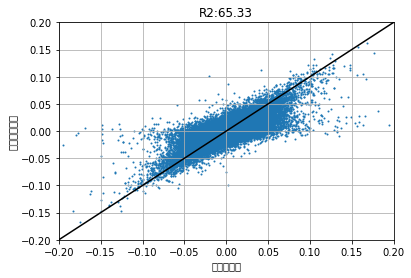

In [148]:
# 決定係数ベースでモデルの評価を実施
print(calcu_r_squared(x_train_org, decoded_return))
plot_scatter_chart(x_train_org, decoded_return, "insample")

In [149]:
weight, factors = model_factor.predict([x_train_chars, x_train_lag, x_train])
plot_factors(x_train, factors, "image/factor_insample.png")

array([[100.34453 , 100.073875,  99.82718 , ...,  98.392456,  95.69007 ,
         96.35194 ],
       [ 99.85409 ,  99.7497  ,  99.359985, ...,  95.4611  ,  95.704414,
         96.35143 ],
       [ 99.640724,  99.29574 ,  99.502754, ...,  95.89618 ,  96.277725,
         96.365616],
       [ 99.111115,  99.11482 ,  99.36468 , ...,  96.60921 ,  96.724686,
         96.34168 ],
       [ 98.75161 ,  98.6362  ,  99.02996 , ...,  94.623276,  96.49934 ,
         96.34802 ]], dtype=float32)

In [150]:
decoded_return = autoencoder.predict([x_test_chars, x_test_lag, x_test])
decoded_return = x_scaler.inverse_transform(decoded_return)
r_2s = np.array(calcu_r_squared(x_test_org, decoded_return, is_sep=True))

for num_index in range(decoded_return.shape[1]):
    # 累積リターンに変更
    cum_ret = 100 * (1 + x_test_org.iloc[:, num_index]).cumprod()
    cum_ret_decoded = 100 * (1 + decoded_return[:, num_index]).cumprod()

    # 比較してプロット
    plt.figure()
    plt.title("{} R2={}".format(
        x_test.iloc[:, num_index].name, round(r_2s[num_index]*100, 2)), fontname="MS Gothic")
    plt.plot(x_test.index, cum_ret, label="Original")
    plt.plot(x_test.index, cum_ret_decoded, label="After AE")
    plt.legend(loc='upper right')
    plt.show()
    # plt.savefig("image/res_outsample_{}.png".format(num_index))
    # plt.close()

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23455 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12522 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23455 missing from current font.
  font.set_

0.3688111325929103


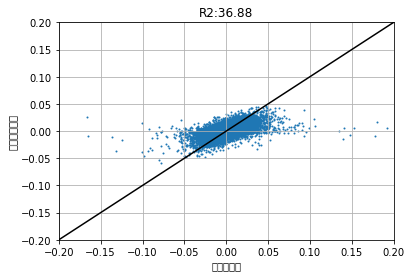

In [151]:
print(calcu_r_squared(x_test_org, decoded_return))
plot_scatter_chart(x_test_org, decoded_return, "outsample")

In [152]:
weight, factors = model_factor.predict([x_train_chars, x_train_lag, x_train])
plot_factors(x_train, factors, "image/factor_insample.png")

array([[100.34453 , 100.073875,  99.82718 , ...,  98.392456,  95.69007 ,
         96.35194 ],
       [ 99.85409 ,  99.7497  ,  99.359985, ...,  95.4611  ,  95.704414,
         96.35143 ],
       [ 99.640724,  99.29574 ,  99.502754, ...,  95.89618 ,  96.277725,
         96.365616],
       [ 99.111115,  99.11482 ,  99.36468 , ...,  96.60921 ,  96.724686,
         96.34168 ],
       [ 98.75161 ,  98.6362  ,  99.02996 , ...,  94.623276,  96.49934 ,
         96.34802 ]], dtype=float32)

In [153]:
pca = PCA(n_components=NUM_FACTOR)
pca.fit(x_train)
pca_factors = pca.transform(x_train)
pca_factors = pca_factors.T

# ---------------------------------------------------------
# PCA:インサンプルの比較
# ---------------------------------------------------------
# デコードされたリターン系列を作成
decoded_return = pca.inverse_transform(pca.transform(x_train))
decoded_return = x_scaler.inverse_transform(decoded_return)
print(calcu_r_squared(x_train_org, decoded_return))

# ---------------------------------------------------------
# PCA:アウトサンプルの比較
# ---------------------------------------------------------
# デコードされたリターン系列を作成
decoded_return = pca.inverse_transform(pca.transform(x_test))
decoded_return = x_scaler.inverse_transform(decoded_return)
print(calcu_r_squared(x_test_org, decoded_return))

0.5195693958687992
0.33117546823873223


## ファクターの解釈

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12502 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65286 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_

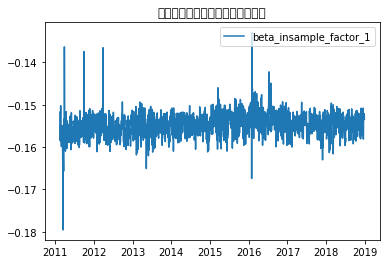

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12502 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65286 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_

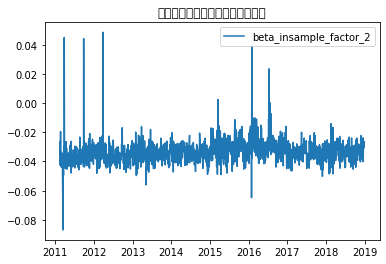

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12502 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65286 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_

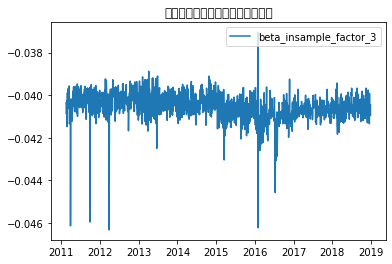

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12502 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65286 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_

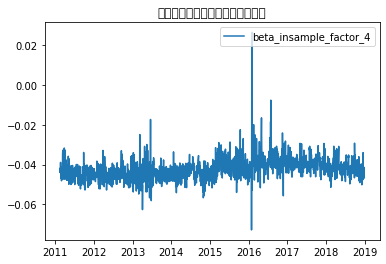

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12475 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12502 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65286 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_

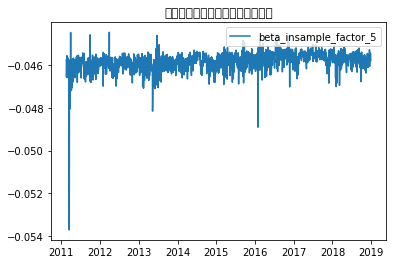

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36234 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

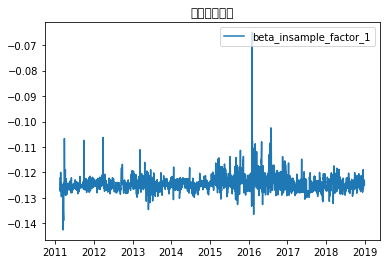

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36234 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

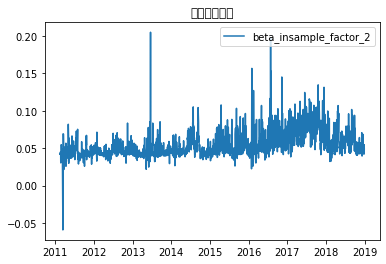

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36234 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

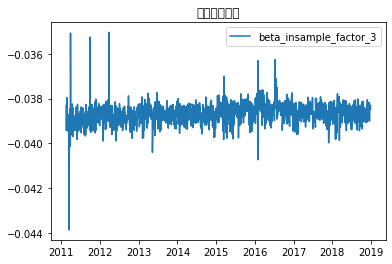

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36234 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

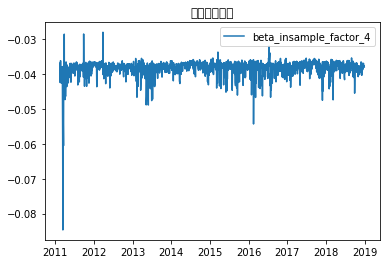

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36234 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

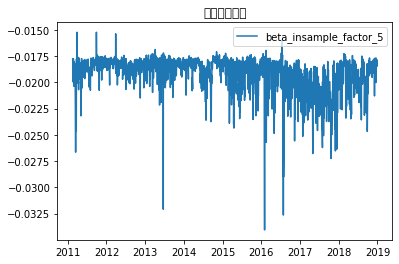

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29579 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 29579 missing from current font.
  font.set_text(s, 0, flags=flags)


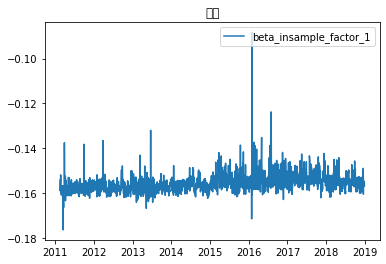

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29579 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 29579 missing from current font.
  font.set_text(s, 0, flags=flags)


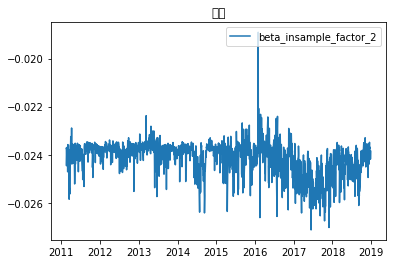

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29579 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 29579 missing from current font.
  font.set_text(s, 0, flags=flags)


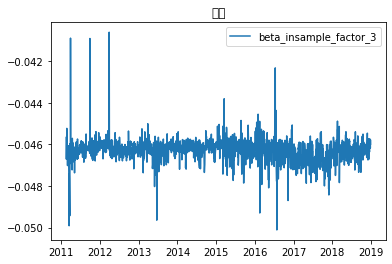

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29579 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 29579 missing from current font.
  font.set_text(s, 0, flags=flags)


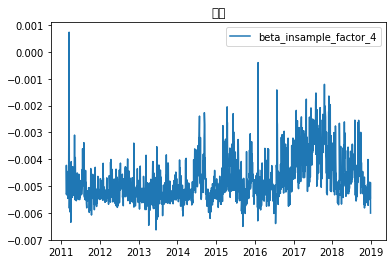

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29579 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 29579 missing from current font.
  font.set_text(s, 0, flags=flags)


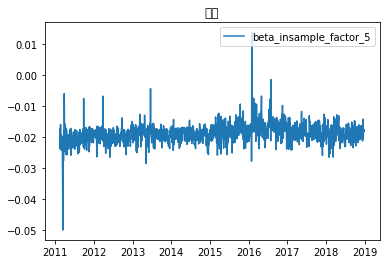

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34220 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21697 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

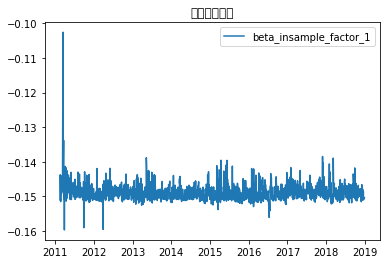

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34220 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21697 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

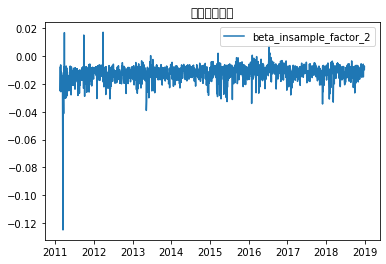

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34220 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21697 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

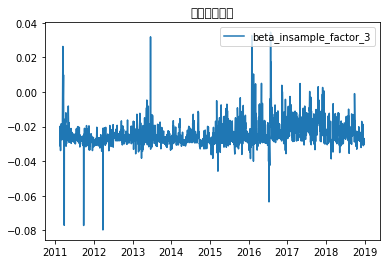

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34220 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21697 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

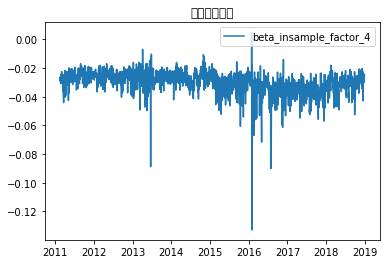

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34220 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21697 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

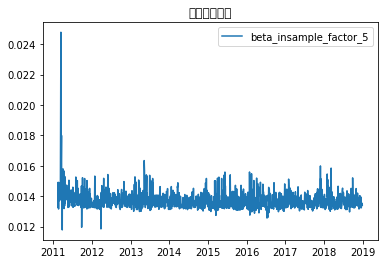

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34220 missing from current font.
  font.set_

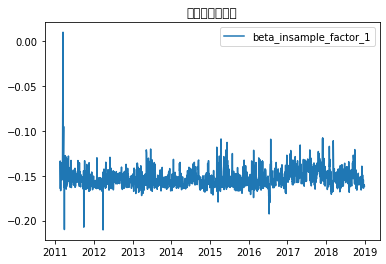

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34220 missing from current font.
  font.set_

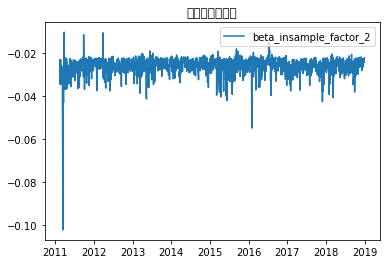

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34220 missing from current font.
  font.set_

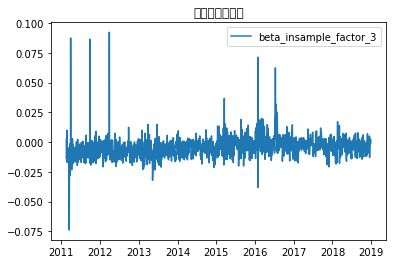

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34220 missing from current font.
  font.set_

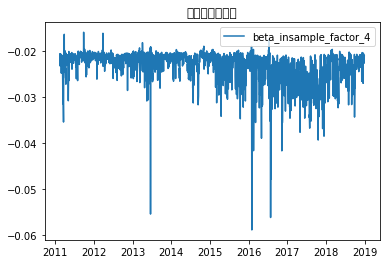

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 34220 missing from current font.
  font.set_

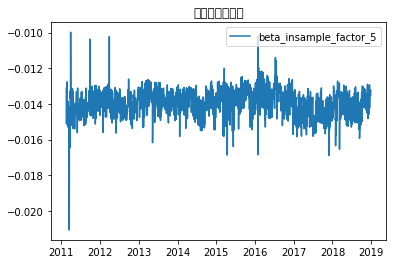

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19977 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_te

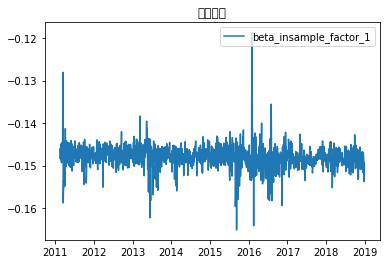

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19977 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_te

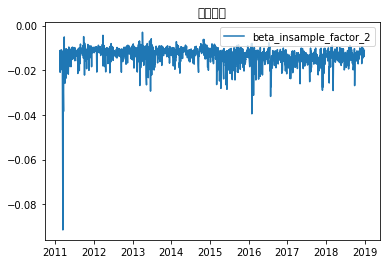

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19977 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_te

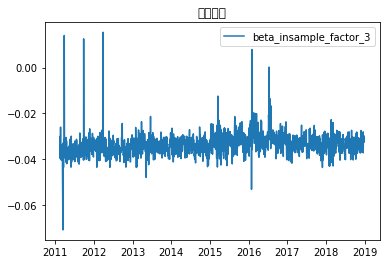

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19977 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_te

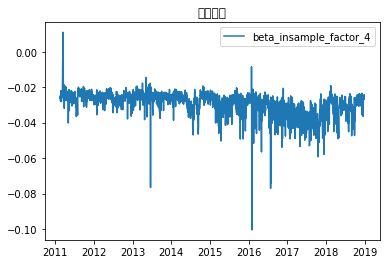

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19977 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20849 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31532 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_te

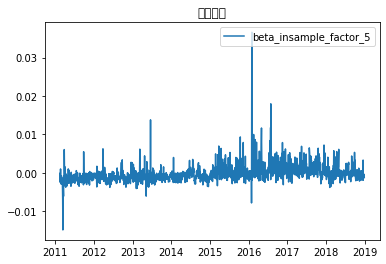

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12461 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

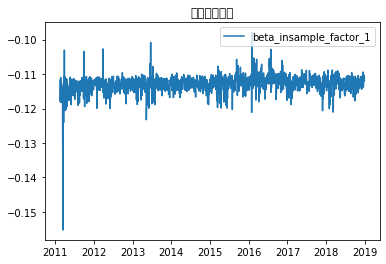

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12461 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

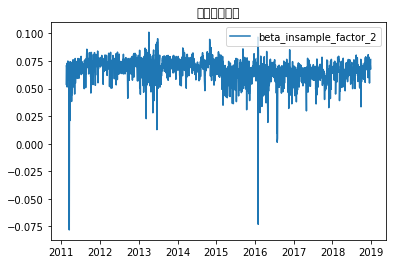

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12461 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

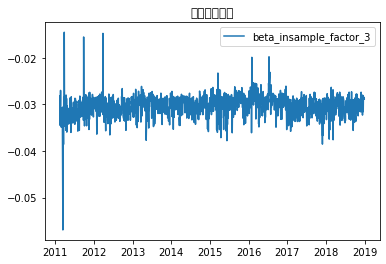

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12461 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

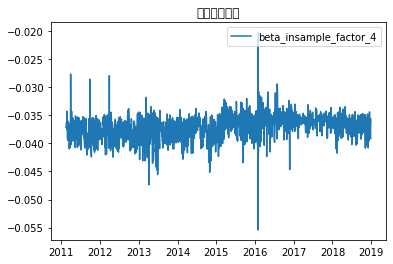

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12461 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24037 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26989 missing from current font.
  font.set_

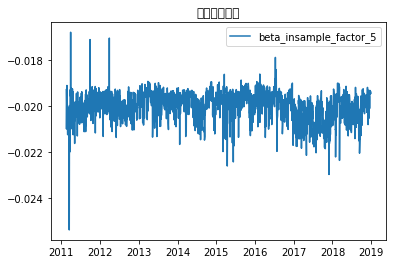

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31435 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20316 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_

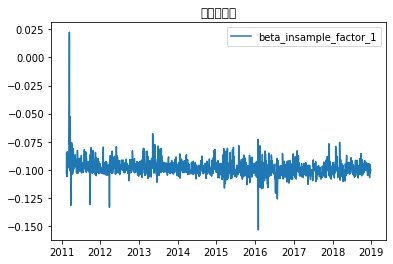

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31435 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20316 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_

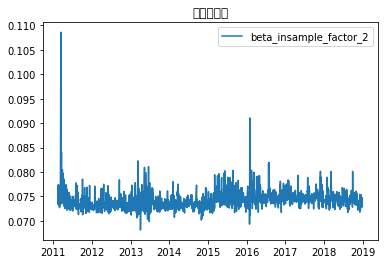

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31435 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20316 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_

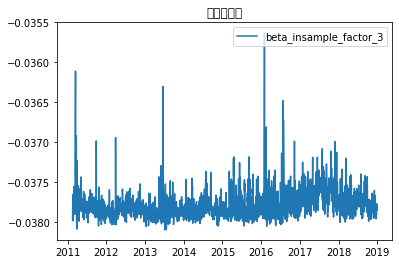

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31435 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20316 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_

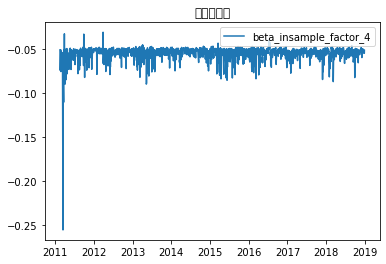

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31435 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20316 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_

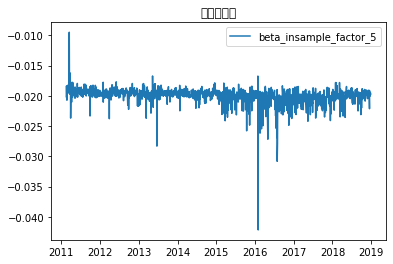

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38651 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_te

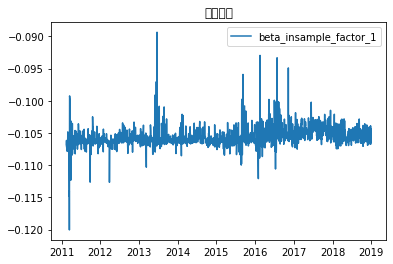

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38651 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_te

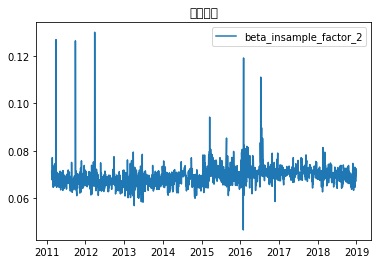

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38651 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_te

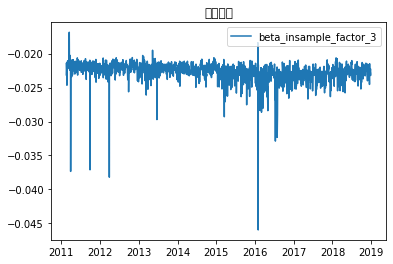

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38651 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_te

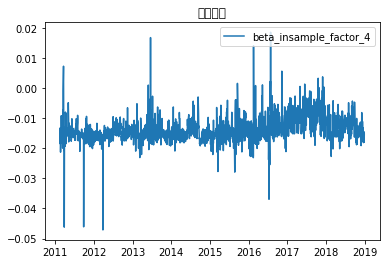

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38651 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_te

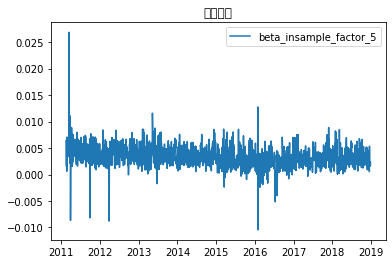

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12477 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12477 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12491 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text

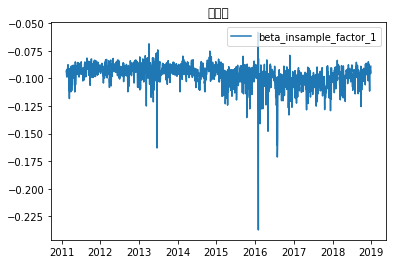

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12477 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12477 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12491 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text

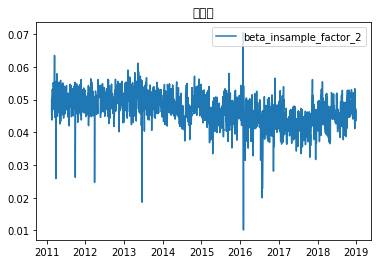

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12477 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12477 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12491 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text

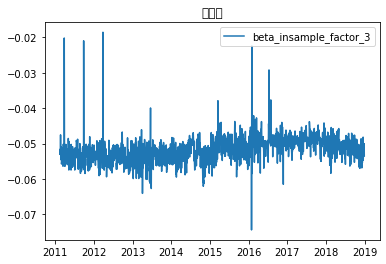

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12477 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12477 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12491 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text

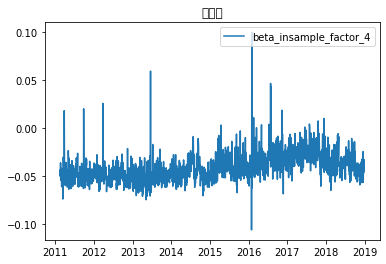

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12477 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12477 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12491 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text

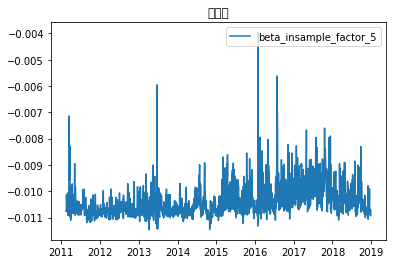

In [154]:
# ファクター系列を確認
weight, factors = model_factor.predict([x_train_chars, x_train_lag, x_train])
plot_factors(x_train, factors, "image/factor_insample.png")

# ベータ系列を確認・解釈
betas = model_beta.predict(x_train_chars)
for i_firm in range(NUM_PLOT):
    firm_name = x_train.iloc[:, i_firm].name
    for i_factor in range(NUM_FACTOR):
        beta = betas.T[i_factor][i_firm]

        plt.figure()
        plt.title(firm_name, fontname="MS Gothic")
        plt.plot(x_train.index, beta, label="beta_insample_factor_{}".format(
            i_factor+1))
        plt.legend(loc='upper right')
        plt.show()
        # plt.savefig(
        #     "image/beta_insample_{}_factor_{}".format(firm_name, i_factor+1))
        # plt.close()

In [155]:
weight, factors = model_factor.predict([x_train_chars, x_train_lag, x_train])
factors = factors.T

# 平均0%・標準偏差年率10%にスケーリング（年間260日基準）
for i in range(NUM_FACTOR):
    m = np.mean(factors[i])
    sd = np.std(factors[i])
    factors[i] = [(f - m) / sd * (0.1 / math.sqrt(260))
                  for f in factors[i]]
factor_data = pd.DataFrame(factors).T
factor_data.index = x_train.index
factor_data.columns = ["factor_{}".format(i+1) for i in range(NUM_FACTOR)]

# 経済データを取得
factor_data["日経225"] = pdr.DataReader(
    '^N225', 'yahoo', TRAIN_START, TRAIN_END)['Close'].pct_change()
factor_data["ドル円"] = pdr.DataReader(
    'JPY=X', 'yahoo', TRAIN_START, TRAIN_END)['Close'].pct_change()

# MOMとVOL
asset_mom = pd.read_csv("stats/mom_factor_ret.csv", encoding="shift_jis", index_col=0).dropna()
asset_vol = pd.read_csv("stats/vol_factor_ret.csv", encoding="shift_jis", index_col=0).dropna()
asset_mom.index = np.array([datetime.strptime(x, '%Y/%m/%d')
                               for x in asset_mom.index])
asset_vol.index = np.array([datetime.strptime(x, '%Y/%m/%d')
                               for x in asset_vol.index])
# 共通部分のみ使用する
factor_data["MOM"] = asset_mom
factor_data["VOL"] = asset_vol
factor_data = factor_data.dropna()
factor_corr = factor_data.corr()
factor_corr.to_csv("factor_corr.csv", encoding="shift_jis")
print(factor_corr)

          factor_1  factor_2  factor_3  ...       ドル円       MOM       VOL
factor_1  1.000000 -0.141619 -0.304497  ... -0.288676 -0.209168 -0.214976
factor_2 -0.141619  1.000000 -0.043982  ...  0.187955 -0.348238  0.505091
factor_3 -0.304497 -0.043982  1.000000  ...  0.049567  0.280038 -0.034837
factor_4 -0.020353 -0.341280 -0.044014  ... -0.190335  0.359841 -0.338758
factor_5 -0.032682 -0.076301 -0.124065  ... -0.123203 -0.117152 -0.265574
日経225    -0.832350  0.459152  0.108294  ...  0.362349 -0.032352  0.442992
ドル円      -0.288676  0.187955  0.049567  ...  1.000000 -0.013842  0.183256
MOM      -0.209168 -0.348238  0.280038  ... -0.013842  1.000000  0.063309
VOL      -0.214976  0.505091 -0.034837  ...  0.183256  0.063309  1.000000

[9 rows x 9 columns]
